In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU())
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.SELU(),
                                        nn.Linear(32, 8),
                                        nn.SELU(),
                                        nn.Linear(8, 1))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.regressor(x)
        return x

In [5]:
data_name = "icsd_221_cp5_3_species"
fig_folder = "plots_SELU/"

In [6]:
df = pd.read_pickle(f"data/{data_name}.pkl")
df = drop_duplicates(df)
df

Number of molecules 377


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:c2bae074d76f81b6,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag1F3...,Ag1F3Zn1,"[1, 3, 1]","[Ag, F, Zn]",5,221,cP5,"[3.979183, 3.979183, 3.979183, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.0], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.98959, 1.98959, -0.0], [0...",-3.35725,None
1,aflow:c568d79d0d0e9fc8,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag1Mn...,Ag1Mn3N1,"[1, 3, 1]","[Ag, Mn, N]",5,221,cP5,"[4.265445, 4.265445, 4.265445, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 2.13272, 2.13272], [2....",-5.99960,None
2,aflow:8944b3eb2c189cb7,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag1Nb...,Ag1Nb1O3,"[1, 1, 3]","[Ag, Nb, O]",5,221,cP5,"[4.000268, 4.000268, 4.000268, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[2.00013, 2.00013, 2.00013], [0.0, 0.0, 0.0],...",-6.76521,None
3,aflow:9da57f587b92d20f,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Ag3I1...,Ag3I1S1,"[3, 1, 1]","[Ag, I, S]",5,221,cP5,"[5.0311, 5.0311, 5.0311, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[2.51555, 2.51555, 0.0], [-0.0, 2.51555, 2.51...",-1.61106,None
4,aflow:d43abd3deaeccc51,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/Al1Bi...,Al1Bi1O3,"[1, 1, 3]","[Al, Bi, O]",5,221,cP5,"[3.793297, 3.793297, 3.793297, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.0, 0.5, ...","[[1.89665, 1.89665, 1.89665], [0.0, 0.0, 0.0],...",-6.54116,-2.28122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,aflow:f2a5b2edf497bb0b,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sn1...,O3Sn1Ti1,"[3, 1, 1]","[O, Sn, Ti]",5,221,cP5,"[3.980776, 3.980776, 3.980776, 90.0, 90.0, 90.0]","[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[1.99039, 1.99039, -0.0], [0.0, 1.99039, 1.99...",-6.92630,None
723,aflow:493eb6e26780d785,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sr1...,O3Sr1Tc1,"[3, 1, 1]","[O, Sr, Tc]",5,221,cP5,"[4.045254, 4.045254, 4.045254, 90.0, 90.0, 90.0]","[[0.5, 0.0, 0.0], [0.0, 0.5, 0.0], [0.0, 0.0, ...","[[2.02263, 0.0, 0.0], [0.0, 2.02263, 0.0], [-0...",-6.91254,None
725,aflow:37c7f43d3abe11ce,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sr1...,O3Sr1Ti1,"[3, 1, 1]","[O, Sr, Ti]",5,221,cP5,"[3.97291, 3.97291, 3.97291, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 1.98645, 1.98645], [1.98645, 0.0, 1.986...",-7.47382,None
751,aflow:6381b955a3963bf3,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/CUB/O3Sr1...,O3Sr1V1,"[3, 1, 1]","[O, Sr, V]",5,221,cP5,"[3.897829, 3.897829, 3.897829, 90.0, 90.0, 90.0]","[[0.5, 0.0, 0.0], [0.0, 0.5, 0.0], [0.0, 0.0, ...","[[1.94891, 0.0, -0.0], [-0.0, 1.94891, 0.0], [...",-7.35920,None


In [7]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

(339, 13) (38, 13)


In [8]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(76,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir',
        'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd',
        'Ni', 'O', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Rh',
        'Ru', 'S', 'Sb', 'Sc', 'Si', 'Sn', 'Sr', 'Ta', 'Tb', 'Tc', 'Th',
        'Ti', 'Tl', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr'],
       dtype='<U2'))

In [9]:
net = VoxelNet(nchannel)
count_parameters(net)

79777

Initialised MolLoader with 339 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 38 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 24.599349975585938 val loss 12.597245216369629
Epoch 1: train loss 5.621312141418457 val loss 6.913987636566162
Epoch 2: train loss 5.271667957305908 val loss 3.063370943069458
Epoch 3: train loss 3.7301764488220215 val loss 4.598057746887207
Epoch 4: train loss 3.598426103591919 val loss 2.775738477706909
Epoch 5: train loss 3.027575731277466 val loss 2.9889979362487793
Epoch 6: train loss 2.8957526683807373 val loss 2.8155617713928223
Epoch 7: train loss 2.8280811309814453 val loss 2.941995143890381
Epoch 8: train loss 2.7269210815429688 val loss 2.6368885040283203
Epoch 9: train loss 2.6946938037872314 val loss 2.6189937591552734
Epoch 10: train loss 2.6277859210968018 val loss 2.643926620

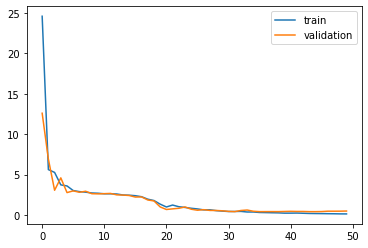

In [10]:
L = 12.8
sigma = 0.1
N = 32
epochs = 50

seed_everything()
device = get_default_device()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=False)

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device, reduce_data=False)

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

### Train Plots

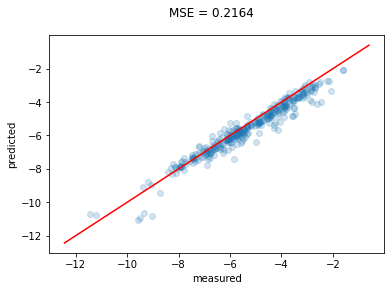

In [11]:
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

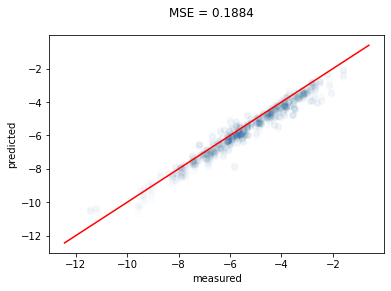

In [12]:
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

### Test Plots

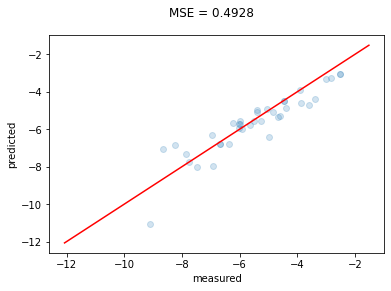

In [13]:
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

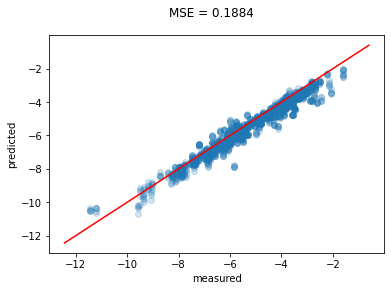

In [14]:
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)
plt.savefig(fig_folder + data_name + "_cartesian_test.pdf")

Initialised LazyMolLoader with 339 molecules. sigma=0.1, L=12.8, N=32, nchannel=76, shuffle=True, rotate=True, device=cuda
Initialised LazyMolLoader with 38 molecules. sigma=0.1, L=12.8, N=32, nchannel=76, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 24.599349975585938 val loss 12.597245216369629
Epoch 1: train loss 5.621312141418457 val loss 6.913987636566162
Epoch 2: train loss 5.271667957305908 val loss 3.063370943069458
Epoch 3: train loss 3.7301764488220215 val loss 4.598057746887207
Epoch 4: train loss 3.598426103591919 val loss 2.775738477706909
Epoch 5: train loss 3.027575731277466 val loss 2.9889979362487793
Epoch 6: train loss 2.8957526683807373 val loss 2.8155617713928223
Epoch 7: train loss 2.8280811309814453 val loss 2.941995143890381
Epoch 8: train loss 2.7269210815429688 val loss 2.6368885040283203
Epoch 9: train loss 2.6946938037872314 val loss 2.6189937591552734
Epoch 10: train loss 2.6277859210968018 val loss 2.6439266204833984
Epoch 11: train loss 2.6

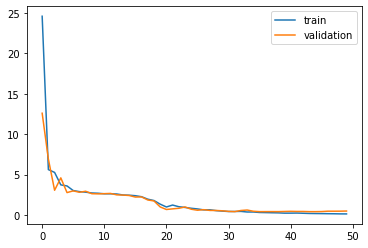

In [15]:
L = 12.8
sigma = 0.1
N = 32
epochs = 50

seed_everything()
device = get_default_device()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = LazyMolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device)

ml_test = LazyMolLoader(test_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device)

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

Initialised MolLoader with 339 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 38 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 24.599349975585938 val loss 12.597245216369629
Epoch 1: train loss 5.621312141418457 val loss 6.913987636566162
Epoch 2: train loss 5.271667957305908 val loss 3.063370943069458
Epoch 3: train loss 3.7301764488220215 val loss 4.598057746887207
Epoch 4: train loss 3.598426103591919 val loss 2.775738477706909
Epoch 5: train loss 3.027575731277466 val loss 2.9889979362487793
Epoch 6: train loss 2.8957526683807373 val loss 2.8155617713928223
Epoch 7: train loss 2.8280811309814453 val loss 2.941995143890381
Epoch 8: train loss 2.7269210815429688 val loss 2.6368885040283203
Epoch 9: train loss 2.6946938037872314 val loss 2.6189937591552734
Epoch 10: train loss 2.6277859210968018 val loss 2.643926620

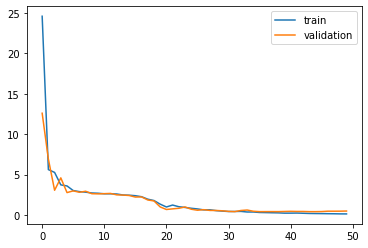

In [16]:
L = 12.8
sigma = 0.1
N = 32
epochs = 50

seed_everything()
device = get_default_device()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True)

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device, reduce_data=True)

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

## Cross Validation

### Cartesian

Initialised MolLoader with 301 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 76 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 25.263412475585938 val loss 16.604951858520508
Epoch 1: train loss 8.72288703918457 val loss 3.3130500316619873
Epoch 2: train loss 5.705549240112305 val loss 3.796133279800415
Epoch 3: train loss 3.1104021072387695 val loss 4.139272689819336
Epoch 4: train loss 3.95151424407959 val loss 4.1649885177612305
Epoch 5: train loss 3.234177589416504 val loss 2.9378371238708496
Epoch 6: train loss 2.8536152839660645 val loss 3.124857187271118
Epoch 7: train loss 2.8800244331359863 val loss 2.8769218921661377
Epoch 8: train loss 2.672416925430298 val loss 3.069931745529175
Epoch 9: train loss 2.7410244941711426 val loss 2.936246156692505
Epoch 10: train loss 2.6188886165618896 val loss 2.826125144958

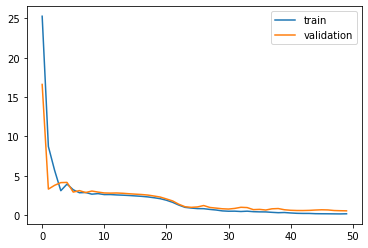

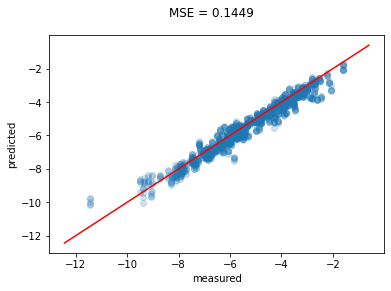

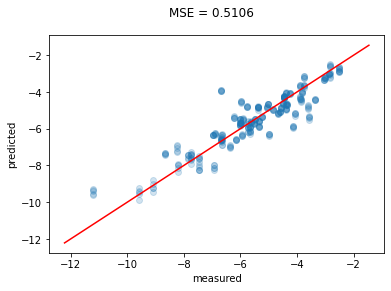

Initialised MolLoader with 301 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 76 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 27.0165958404541 val loss 15.099834442138672
Epoch 1: train loss 6.651175022125244 val loss 6.703883647918701
Epoch 2: train loss 5.859604358673096 val loss 3.2150635719299316
Epoch 3: train loss 3.178947687149048 val loss 4.542232036590576
Epoch 4: train loss 3.7226951122283936 val loss 3.822608470916748
Epoch 5: train loss 2.8661749362945557 val loss 3.179043769836426
Epoch 6: train loss 2.803854465484619 val loss 3.289328098297119
Epoch 7: train loss 2.6947402954101562 val loss 3.139188528060913
Epoch 8: train loss 2.633350372314453 val loss 3.2372212409973145
Epoch 9: train loss 2.612450361251831 val loss 3.0756750106811523
Epoch 10: train loss 2.567309856414795 val loss 3.051291942596435

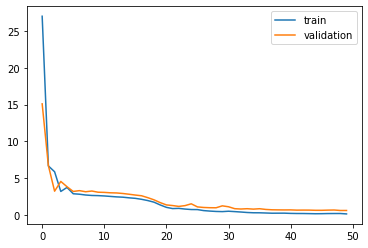

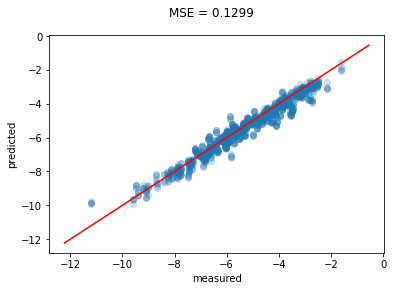

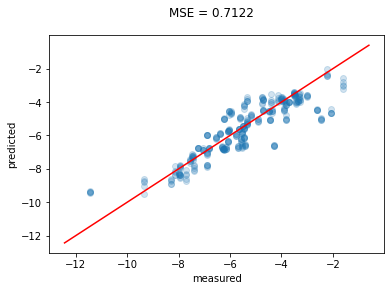

Initialised MolLoader with 302 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 75 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 27.560333251953125 val loss 13.070537567138672
Epoch 1: train loss 10.05300235748291 val loss 3.155710458755493
Epoch 2: train loss 4.206640243530273 val loss 5.334948539733887
Epoch 3: train loss 4.18017053604126 val loss 2.2353391647338867
Epoch 4: train loss 3.4531383514404297 val loss 2.9250259399414062
Epoch 5: train loss 3.4745123386383057 val loss 2.2120041847229004
Epoch 6: train loss 2.9296727180480957 val loss 2.6463780403137207
Epoch 7: train loss 3.1006784439086914 val loss 2.2551956176757812
Epoch 8: train loss 2.856865882873535 val loss 2.200139045715332
Epoch 9: train loss 2.918912172317505 val loss 2.1657111644744873
Epoch 10: train loss 2.8261830806732178 val loss 2.188668489

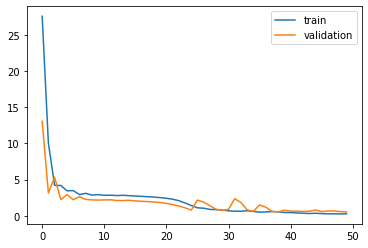

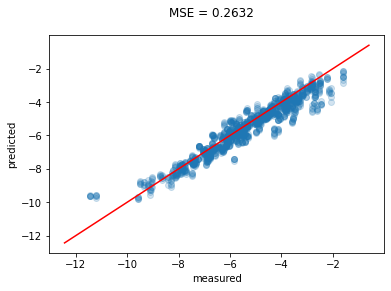

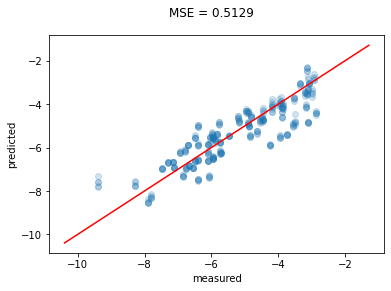

Initialised MolLoader with 302 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 75 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 25.49201011657715 val loss 13.27616024017334
Epoch 1: train loss 9.49996566772461 val loss 2.759568691253662
Epoch 2: train loss 5.1572957038879395 val loss 5.602304935455322
Epoch 3: train loss 3.361454725265503 val loss 2.9420228004455566
Epoch 4: train loss 3.7108850479125977 val loss 3.190264940261841
Epoch 5: train loss 3.2827773094177246 val loss 2.7870614528656006
Epoch 6: train loss 2.9207425117492676 val loss 3.410595178604126
Epoch 7: train loss 2.8129734992980957 val loss 2.7093608379364014
Epoch 8: train loss 2.7798187732696533 val loss 2.676363468170166
Epoch 9: train loss 2.7466318607330322 val loss 2.723598003387451
Epoch 10: train loss 2.6471731662750244 val loss 2.88516306877

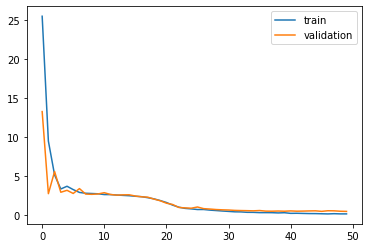

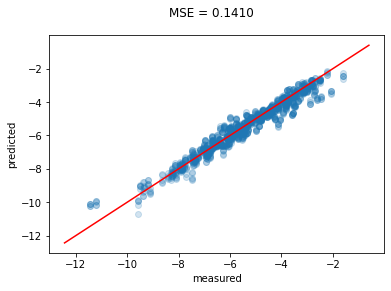

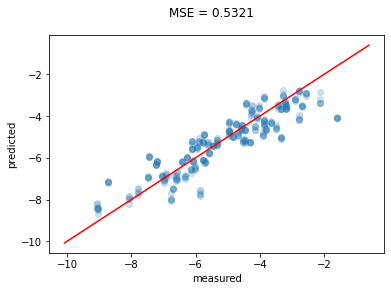

Initialised MolLoader with 302 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 75 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 23.683319091796875 val loss 14.749886512756348
Epoch 1: train loss 8.189189910888672 val loss 2.70977783203125
Epoch 2: train loss 4.522417068481445 val loss 3.294069290161133
Epoch 3: train loss 2.969700336456299 val loss 4.036477565765381
Epoch 4: train loss 3.6993443965911865 val loss 3.1816964149475098
Epoch 5: train loss 2.979139804840088 val loss 2.7519149780273438
Epoch 6: train loss 2.988542079925537 val loss 2.637878894805908
Epoch 7: train loss 2.8121495246887207 val loss 3.0361881256103516
Epoch 8: train loss 2.855189800262451 val loss 2.707801103591919
Epoch 9: train loss 2.7253835201263428 val loss 2.5967230796813965
Epoch 10: train loss 2.724437952041626 val loss 2.6184554100036

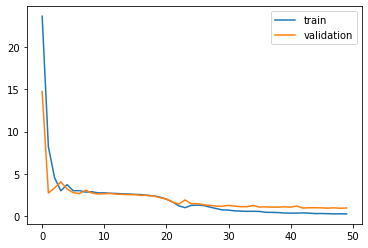

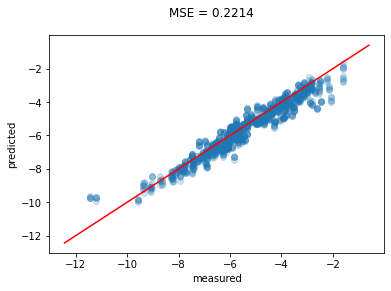

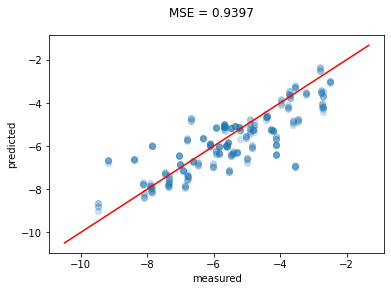

In [17]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

all_train_ys = []
all_train_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_train_ys.append(ys)
    all_train_y_hats.append(y_hats)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_ys.append(ys)
    all_y_hats.append(y_hats)

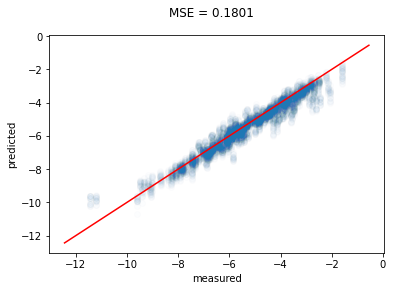

In [18]:
# 0.1801 50 epoch
plot_predictions(np.hstack(all_train_ys), np.hstack(all_train_y_hats), alpha=0.01)
plt.show()

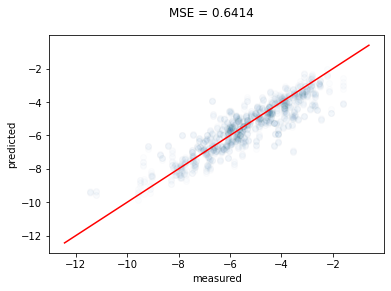

In [19]:
# 0.6414 50 epoch
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_cv.pdf")

### Spherical

Initialised MolLoader with 301 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 76 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 25.263412475585938 val loss 16.604951858520508
Epoch 1: train loss 8.72288703918457 val loss 3.3130500316619873
Epoch 2: train loss 5.705549240112305 val loss 3.796133279800415
Epoch 3: train loss 3.1104021072387695 val loss 4.139272689819336
Epoch 4: train loss 3.95151424407959 val loss 4.1649885177612305
Epoch 5: train loss 3.234177589416504 val loss 2.9378371238708496
Epoch 6: train loss 2.8536152839660645 val loss 3.124857187271118
Epoch 7: train loss 2.8800244331359863 val loss 2.8769218921661377
Epoch 8: train loss 2.672416925430298 val loss 3.069931745529175
Epoch 9: train loss 2.7410244941711426 val loss 2.936246156692505
Epoch 10: train loss 2.6188886165618896 val loss 2.826125144958

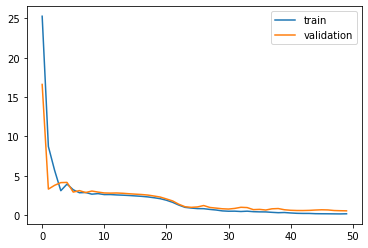

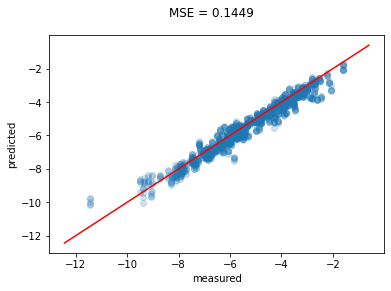

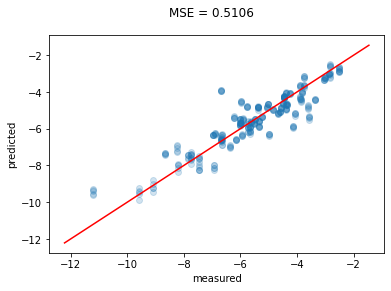

Initialised MolLoader with 301 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 76 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 27.0165958404541 val loss 15.099834442138672
Epoch 1: train loss 6.651175022125244 val loss 6.703883647918701
Epoch 2: train loss 5.859604358673096 val loss 3.2150635719299316
Epoch 3: train loss 3.178947687149048 val loss 4.542232036590576
Epoch 4: train loss 3.7226951122283936 val loss 3.822608470916748
Epoch 5: train loss 2.8661749362945557 val loss 3.179043769836426
Epoch 6: train loss 2.803854465484619 val loss 3.289328098297119
Epoch 7: train loss 2.6947402954101562 val loss 3.139188528060913
Epoch 8: train loss 2.633350372314453 val loss 3.2372212409973145
Epoch 9: train loss 2.612450361251831 val loss 3.0756750106811523
Epoch 10: train loss 2.567309856414795 val loss 3.051291942596435

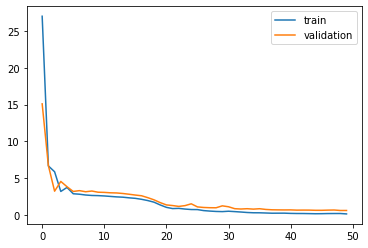

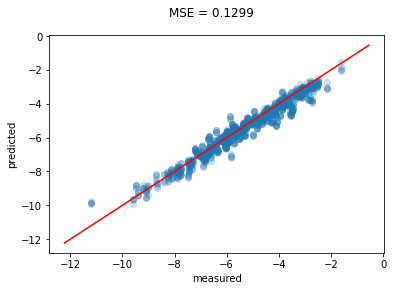

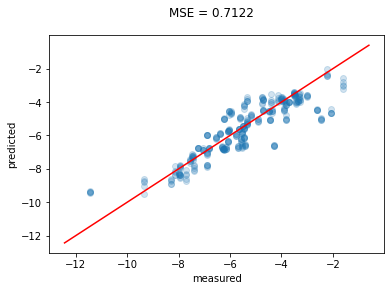

Initialised MolLoader with 302 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 75 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 27.560333251953125 val loss 13.070537567138672
Epoch 1: train loss 10.05300235748291 val loss 3.155710458755493
Epoch 2: train loss 4.206640243530273 val loss 5.334948539733887
Epoch 3: train loss 4.18017053604126 val loss 2.2353391647338867
Epoch 4: train loss 3.4531383514404297 val loss 2.9250259399414062
Epoch 5: train loss 3.4745123386383057 val loss 2.2120041847229004
Epoch 6: train loss 2.9296727180480957 val loss 2.6463780403137207
Epoch 7: train loss 3.1006784439086914 val loss 2.2551956176757812
Epoch 8: train loss 2.856865882873535 val loss 2.200139045715332
Epoch 9: train loss 2.918912172317505 val loss 2.1657111644744873
Epoch 10: train loss 2.8261830806732178 val loss 2.188668489

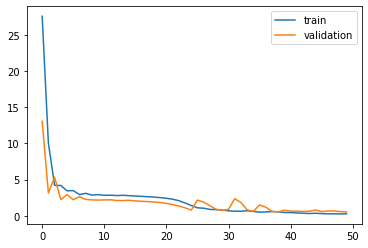

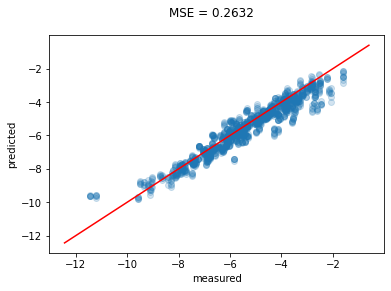

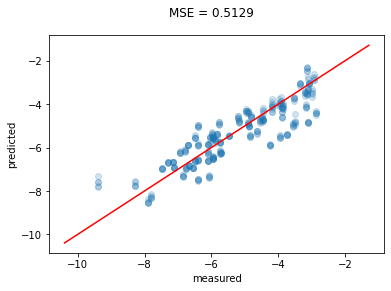

Initialised MolLoader with 302 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 75 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 25.49201011657715 val loss 13.27616024017334
Epoch 1: train loss 9.49996566772461 val loss 2.759568691253662
Epoch 2: train loss 5.1572957038879395 val loss 5.602304935455322
Epoch 3: train loss 3.361454725265503 val loss 2.9420228004455566
Epoch 4: train loss 3.7108850479125977 val loss 3.190264940261841
Epoch 5: train loss 3.2827773094177246 val loss 2.7870614528656006
Epoch 6: train loss 2.9207425117492676 val loss 3.410595178604126
Epoch 7: train loss 2.8129734992980957 val loss 2.7093608379364014
Epoch 8: train loss 2.7798187732696533 val loss 2.676363468170166
Epoch 9: train loss 2.7466318607330322 val loss 2.723598003387451
Epoch 10: train loss 2.6471731662750244 val loss 2.88516306877

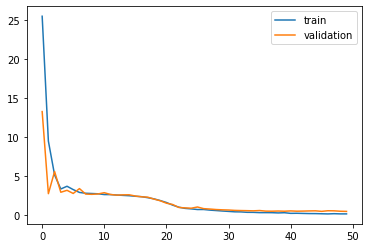

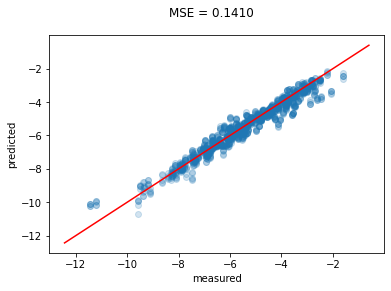

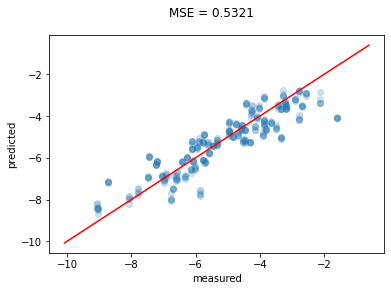

Initialised MolLoader with 302 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 75 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=76, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 23.683319091796875 val loss 14.749886512756348
Epoch 1: train loss 8.189189910888672 val loss 2.70977783203125
Epoch 2: train loss 4.522417068481445 val loss 3.294069290161133
Epoch 3: train loss 2.969700336456299 val loss 4.036477565765381
Epoch 4: train loss 3.6993443965911865 val loss 3.1816964149475098
Epoch 5: train loss 2.979139804840088 val loss 2.7519149780273438
Epoch 6: train loss 2.988542079925537 val loss 2.637878894805908
Epoch 7: train loss 2.8121495246887207 val loss 3.0361881256103516
Epoch 8: train loss 2.855189800262451 val loss 2.707801103591919
Epoch 9: train loss 2.7253835201263428 val loss 2.5967230796813965
Epoch 10: train loss 2.724437952041626 val loss 2.6184554100036

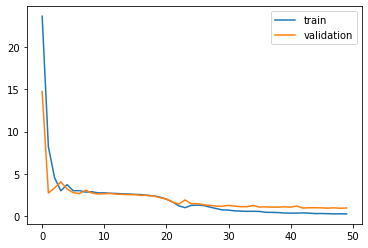

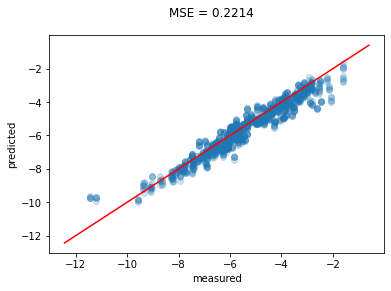

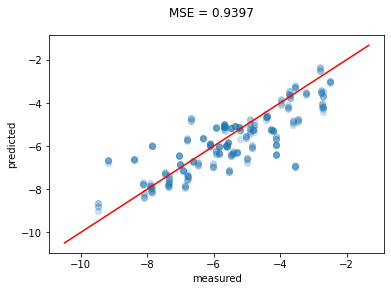

In [20]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

all_train_ys = []
all_train_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_train_ys.append(ys)
    all_train_y_hats.append(y_hats)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_ys.append(ys)
    all_y_hats.append(y_hats)

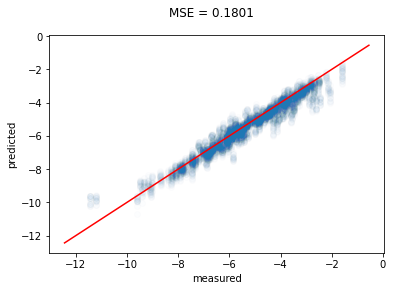

In [21]:
# 0.1801 50 epochs
plot_predictions(np.hstack(all_train_ys), np.hstack(all_train_y_hats), alpha=0.01)
plt.show()

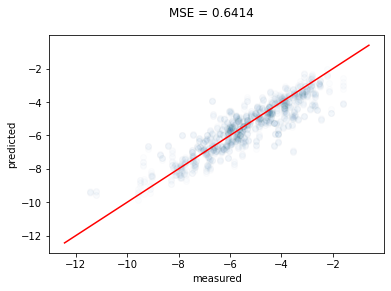

In [22]:
# 0.6414 50 epochs
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_cv.pdf")